# Rating Product & Sorting Reviews in Amazon

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from scipy import stats as st

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [2]:
######### changeable #########
csv_name = "amazon_review.csv"
##############################

csv_path = os.path.realpath(csv_name)

df = pd.read_csv(csv_path)

df = df[["reviewerID", "reviewText", "overall", "reviewTime", "helpful_yes", "total_vote"]]

df.head(10)

,reviewerID,reviewText,overall,reviewTime,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,No issues.,4.00000,2014-07-23,0,0
1,A18K1ODH1I2MVB,"Purchased this for my device, it worked as adv...",5.00000,2013-10-25,0,0
2,A2FII3I2MBMUIA,it works as expected. I should have sprung for...,4.00000,2012-12-23,0,0
3,A3H99DFEG68SR,This think has worked out great.Had a diff. br...,5.00000,2013-11-21,0,0
4,A375ZM4U047O79,"Bought it with Retail Packaging, arrived legit...",5.00000,2013-07-13,0,0
5,A2IDCSC6NVONIZ,It's mini storage. It doesn't do anything els...,5.00000,2013-04-29,0,0
6,A26YHXZD5UFPVQ,I have it in my phone and it never skips a bea...,5.00000,2013-10-19,0,0
7,A3CW0ZLUO5X2B1,It's hard to believe how affordable digital ha...,5.00000,2014-10-07,0,0
8,A2CYJO155QP33S,Works in a HTC Rezound. Was running short of ...,5.00000,2014-03-24,1,1
9,A2S7XG3ZC4VGOQ,"in my galaxy s4, super fast card, and am total...",5.00000,2013-11-10,0,0


In [3]:
print(" Information About Entries ".center(70, "#"))
display(df.info())
print(" NA Value Information ".center(70, "#"))
display(df.isnull().sum())
print(" Statistics Information ".center(70, "#"))
display(df.describe().T)

##################### Information About Entries ######################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewerID   4915 non-null   object 
 1   reviewText   4914 non-null   object 
 2   overall      4915 non-null   float64
 3   reviewTime   4915 non-null   object 
 4   helpful_yes  4915 non-null   int64  
 5   total_vote   4915 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 230.5+ KB


None

######################## NA Value Information ########################


reviewerID     0
reviewText     1
overall        0
reviewTime     0
helpful_yes    0
total_vote     0
dtype: int64

####################### Statistics Information #######################


,count,mean,std,min,25%,50%,75%,max
overall,4915.00000,4.58759,0.99685,1.00000,5.00000,5.00000,5.00000,5.00000
helpful_yes,4915.00000,1.31109,41.61916,0.00000,0.00000,0.00000,0.00000,1952.00000
total_vote,4915.00000,1.52146,44.12309,0.00000,0.00000,0.00000,0.00000,2020.00000


In short, when we examine the results, there is one NA value in the "reviewText" feature, we can drop it.

In [4]:
df.dropna(inplace=True)

# Rating Product

There are some techniques we will use in rating product:

* Average

* Time-Based Weighted Average

* User-Based Weighted Average

* Weighted Rating

Here we will examine **Average** and **Time-Based Weighted Average** techniques.

### Average

In [5]:
# The overall score average of the product
df["overall"].mean()

4.587505087505088

### Time-Based Weighted Average

When we want to determine a product's rating, there is one factor that is overlooked: the "satisfaction trend". People's opinions on a product will differ from time to time. When a person uses it in the first three months, it will score differently, and if there is a problem with the product for the next three months, the person will perform a different rating. For these reasons, it may be useful to have a coefficient of times in the final scoring of the product.

4.6957928802588995 4.636140637775961 4.571661237785016 4.445802770986145


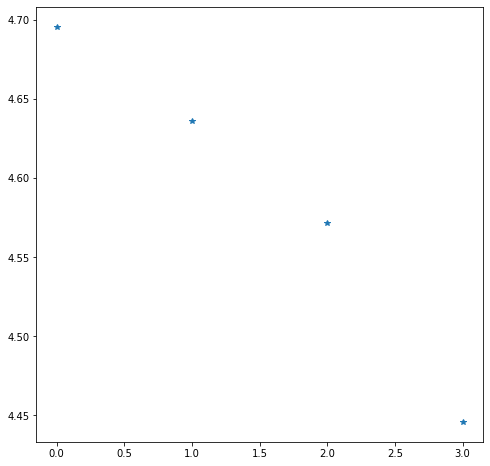

In [6]:
# average ratings of the products in the range of determined quantile values

df["reviewTime"] = pd.to_datetime(df["reviewTime"], dayfirst=True) # gün ve ayın yeri değişik olabilir

current_date = df["reviewTime"].max()

df["days"] = (current_date - df["reviewTime"]).dt.days

q1 = df["days"].quantile(0.25)
q2 = df["days"].quantile(0.5)
q3 = df["days"].quantile(0.75)

avg1 = df.loc[df["days"]<=q1, "overall"].mean() 
avg2 = df.loc[(df["days"]<=q2) & (df["days"]>q1) , "overall"].mean()
avg3 = df.loc[(df["days"]<=q3) & (df["days"]>q2), "overall"].mean()
avg4 = df.loc[df["days"]>q3, "overall"].mean()

print(avg1, avg2, avg3, avg4)

plt.figure(figsize=(8, 8))
plt.plot([avg1, avg2, avg3, avg4], "*")
plt.show()

As the history of the ratings given to the product moves away from the present, the averages decrease.

In [7]:
# Four different weights for the four time intervals created, these may vary according to the companies' own methods.

w1 = 0.50
w2 = 0.25
w3 = 0.15
w4 = 0.10

time_based_avg = avg1 * w1 + avg2 * w2 + avg3 * w3 + avg4 * w4

time_based_avg

4.637261062339807

We can see that the Time-Based Average is greater than the previous average result.

# Sorting Reviews

The ranking of comments is not sorted by the number of positive comments or negative comments. The key factor here is whether the customer finds the review helpful or not. There are three techniques we will use here as well:

* Up-Down Difference Score

* Average Rating Score

* Wilson Lower Bound Score

### Up-Down Difference Score

The value obtained as a result of removing the "helpful_no" vote from the "helpful" game. There is no "helpful_no" feature in the dataset, but there is a "total_vote" feature.

In [8]:
df["helpful_no"] = df["total_vote"] - df["helpful_yes"]

df.head()

,reviewerID,reviewText,overall,reviewTime,helpful_yes,total_vote,days,helpful_no
0,A3SBTW3WS4IQSN,No issues.,4.00000,2014-07-23,0,0,137,0
1,A18K1ODH1I2MVB,"Purchased this for my device, it worked as adv...",5.00000,2013-10-25,0,0,408,0
2,A2FII3I2MBMUIA,it works as expected. I should have sprung for...,4.00000,2012-12-23,0,0,714,0
3,A3H99DFEG68SR,This think has worked out great.Had a diff. br...,5.00000,2013-11-21,0,0,381,0
4,A375ZM4U047O79,"Bought it with Retail Packaging, arrived legit...",5.00000,2013-07-13,0,0,512,0


In [9]:
def up_down_diff_score(up, down):
    return up - down

In [10]:
df["up_down_diff_score"] = df.apply(lambda x: up_down_diff_score(x["helpful_yes"], x["helpful_no"]), axis=1)

df.sort_values(by="up_down_diff_score", ascending=False).head(10)

,reviewerID,reviewText,overall,reviewTime,helpful_yes,total_vote,days,helpful_no,up_down_diff_score
2031,A12B7ZMXFI6IXY,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00000,2013-01-05,1952,2020,701,68,1884
4212,AVBMZZAFEKO58,NOTE: please read the last update (scroll to ...,1.00000,2013-05-08,1568,1694,578,126,1442
3449,AOEAD7DPLZE53,I have tested dozens of SDHC and micro-SDHC ca...,5.00000,2012-09-26,1428,1505,802,77,1351
317,A1ZQAQFYSXL5MQ,"If your card gets hot enough to be painful, it...",1.00000,2012-02-09,422,495,1032,73,349
3981,A1K91XXQ6ZEBQR,The last few days I have been diligently shopp...,5.00000,2012-10-22,112,139,776,27,85
4596,A1WTQUOQ4WG9AI,Hi:I ordered two card and they arrived the nex...,1.00000,2012-09-22,82,109,806,27,55
1835,A1J6VSUM80UAF8,Bought from BestBuy online the day it was anno...,5.00000,2014-02-28,60,68,282,8,52
4672,A2DKQQIZ793AV5,Sandisk announcement of the first 128GB micro ...,5.00000,2014-07-03,45,49,157,4,41
4306,AOHXKM5URSKAB,"While I got this card as a ""deal of the day"" o...",5.00000,2012-09-06,51,65,822,14,37
315,A2J26NNQX6WKAU,Bought this card to use with my Samsung Galaxy...,5.00000,2012-08-13,38,48,846,10,28


### Average Rating Score

Here, we use rate information, but frequency information is important. 

In [11]:
def average_rating_score(up, total):
    # if up + down == 0
    try:
        avg = up / total
    except ZeroDivisionError as e:
        avg = 0
    
    return avg

df["average_rating_score"] = df.apply(lambda x: average_rating_score(x["helpful_yes"], x["total_vote"]), axis=1)

df.sort_values(by="average_rating_score", ascending=False).head(10)

,reviewerID,reviewText,overall,reviewTime,helpful_yes,total_vote,days,helpful_no,up_down_diff_score,average_rating_score
1637,A12R3YGEHW7D8G,Got this for my Dell Venue Pro 8 tablet - work...,5.00000,2014-01-24,1,1,317,0,1,1.00000
3418,A2IL8EBLBZJUEG,There's really not much to say. I put it right...,5.00000,2013-12-31,1,1,341,0,1,1.00000
2188,A36SDGTQ584S7Q,Using dbpoweramp I was able to rip my entire c...,5.00000,2014-05-15,1,1,206,0,1,1.00000
1073,A2ZXEKQ2OBZLEE,I used it with my Samsung S4 and it works grea...,5.00000,2013-08-13,1,1,481,0,1,1.00000
445,AIWBDRNBODLEA,This is exactly what I was looking for to upgr...,4.00000,2013-12-18,1,1,354,0,1,1.00000
3923,A2PH4RGYVR34L,"It's a SanDisk, so what more is there to say? ...",5.00000,2013-12-30,1,1,342,0,1,1.00000
435,AUH8I22ITG020,This is working great in my AT&T Galaxy Note. ...,5.00000,2012-07-24,1,1,866,0,1,1.00000
2901,A28TRYU3FJ039C,Not a good typer or speller :) here is what I ...,5.00000,2013-05-13,1,1,573,0,1,1.00000
2204,AANX2UN8NPE22,I just called Sandisk and they say they have a...,2.00000,2013-06-14,1,1,541,0,1,1.00000
2206,A3KO3964CNP0XN,I bought this for my garmin virb action cam. ...,5.00000,2013-10-31,1,1,402,0,1,1.00000


But there is a problem here. Comments with low frequency, for example:

Review1<br>

* helpful_yes: 2

* helpful_no: 0

* total_vote: 2

Review2<br>

* helpful_yes: 100<br>

* helpful_no: 15

* total_vote: 115

In [12]:
print("review1 : ", average_rating_score(2, 2))
print("review2 : ", average_rating_score(100, 115))

review1 :  1.0
review2 :  0.8695652173913043


There are two different reviews and we consider their reliability. We'll probably say "review2" is more reliable. For this we need to use another technique where frequency is important.

### Wilson Lower Bound Score

Lower bound of Wilson score confidence interval for a Bernoulli parameter provides a way to sort a product based on positive and negative ratings.

In [13]:
def wilson_lower_bound(up, total, confidence=0.95):
    if total == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * up / total
    return (phat + z * z / (2 * total) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * total)) / total)) / (1 + z * z / total)
    
df["wilson_lower_bound"] = df.apply(lambda x: wilson_lower_bound(x["helpful_yes"], x["total_vote"]), axis=1)

df.sort_values(by="wilson_lower_bound", ascending=False).head(20)

,reviewerID,reviewText,overall,reviewTime,helpful_yes,total_vote,days,helpful_no,up_down_diff_score,average_rating_score,wilson_lower_bound
2031,A12B7ZMXFI6IXY,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00000,2013-01-05,1952,2020,701,68,1884,0.96634,0.95754
3449,AOEAD7DPLZE53,I have tested dozens of SDHC and micro-SDHC ca...,5.00000,2012-09-26,1428,1505,802,77,1351,0.94884,0.93652
4212,AVBMZZAFEKO58,NOTE: please read the last update (scroll to ...,1.00000,2013-05-08,1568,1694,578,126,1442,0.92562,0.91214
317,A1ZQAQFYSXL5MQ,"If your card gets hot enough to be painful, it...",1.00000,2012-02-09,422,495,1032,73,349,0.85253,0.81858
4672,A2DKQQIZ793AV5,Sandisk announcement of the first 128GB micro ...,5.00000,2014-07-03,45,49,157,4,41,0.91837,0.80811
1835,A1J6VSUM80UAF8,Bought from BestBuy online the day it was anno...,5.00000,2014-02-28,60,68,282,8,52,0.88235,0.78465
3981,A1K91XXQ6ZEBQR,The last few days I have been diligently shopp...,5.00000,2012-10-22,112,139,776,27,85,0.80576,0.73214
3807,AFGRMORWY2QNX,I bought this card to replace a lost 16 gig in...,3.00000,2013-02-27,22,25,648,3,19,0.88000,0.70044
4306,AOHXKM5URSKAB,"While I got this card as a ""deal of the day"" o...",5.00000,2012-09-06,51,65,822,14,37,0.78462,0.67033
4596,A1WTQUOQ4WG9AI,Hi:I ordered two card and they arrived the nex...,1.00000,2012-09-22,82,109,806,27,55,0.75229,0.66359


Some results:
* According to Wilson Lower Bound ranking, the values that can be considered as outliers in the up-down difference variable are in the first row.

* Frequency problem has been solved for the average rating score. We can see that the observations with low frequency fall into the lower ranks.